In [1]:
# 1. Imports & Config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

sns.set(style='whitegrid')


In [2]:
# 2. Load Data & Quick Overview
df = pd.read_csv("equipment_anomaly_data.csv")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst 5 rows:\n", df.head())
print("\nDescriptive stats:\n", df.describe())


Shape: (7672, 7)
Columns: ['temperature', 'pressure', 'vibration', 'humidity', 'equipment', 'location', 'faulty']

First 5 rows:
    temperature   pressure  vibration   humidity   equipment       location  \
0    58.180180  25.029278   0.606516  45.694907     Turbine        Atlanta   
1    75.740712  22.954018   2.338095  41.867407  Compressor        Chicago   
2    71.358594  27.276830   1.389198  58.954409     Turbine  San Francisco   
3    71.616985  32.242921   1.770690  40.565138        Pump        Atlanta   
4    66.506832  45.197471   0.345398  43.253795        Pump       New York   

   faulty  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  

Descriptive stats:
        temperature     pressure    vibration     humidity       faulty
count  7672.000000  7672.000000  7672.000000  7672.000000  7672.000000
mean     70.922478    35.738048     1.611809    50.016574     0.099974
std      16.200059    10.381593     0.728560    11.841479     0.299985
min      10.269385     3

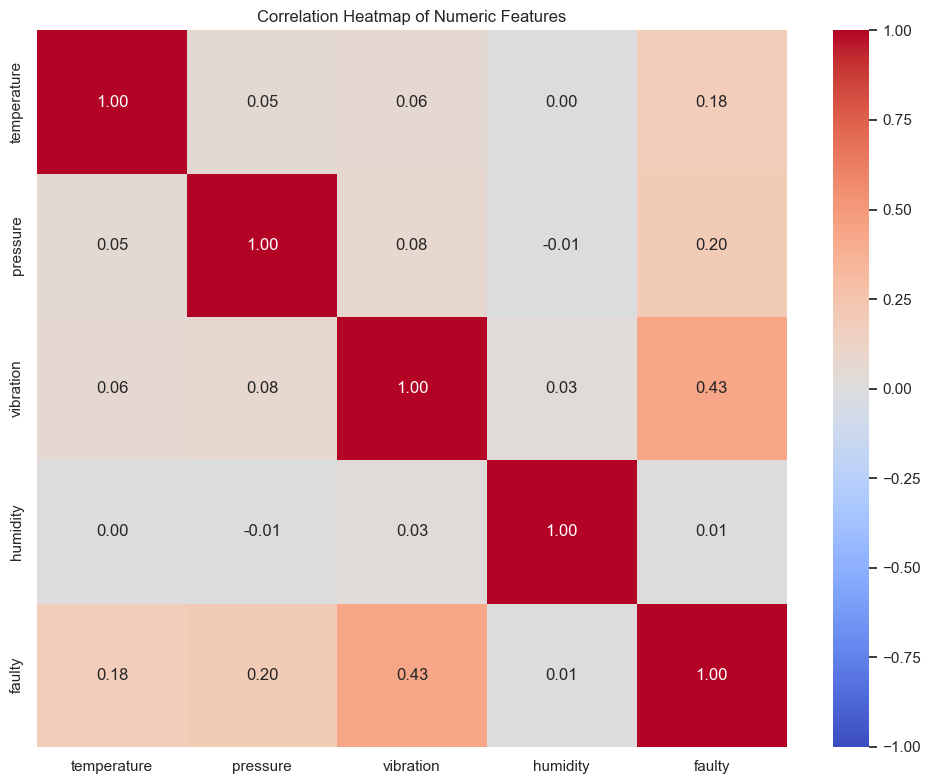

In [3]:
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10,8))
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1, vmax=1
)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()


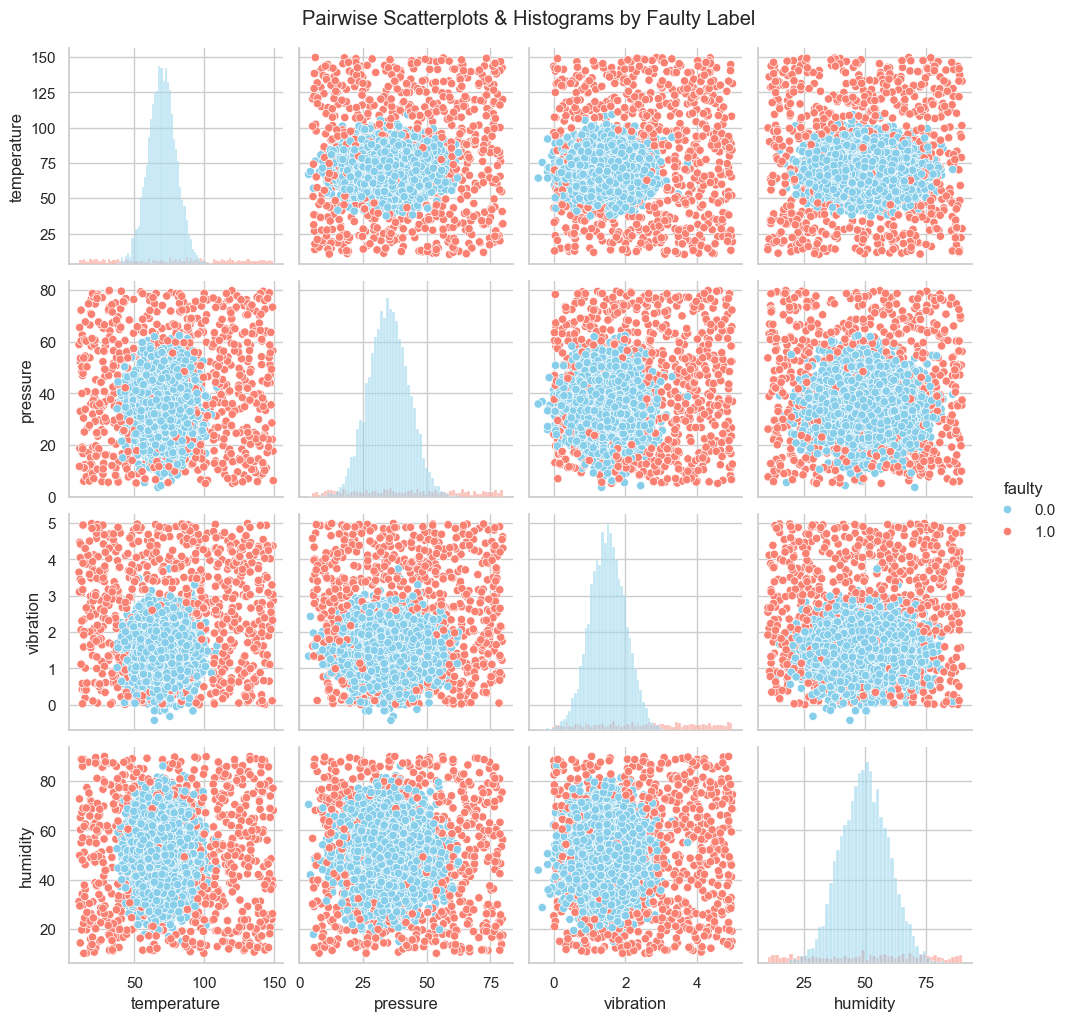

In [4]:
sns.pairplot(numeric_df, hue='faulty', diag_kind='hist', palette=['skyblue','salmon'])
plt.suptitle("Pairwise Scatterplots & Histograms by Faulty Label", y=1.02)
plt.show()


In [5]:
# 3. Prepare Data for Modeling
numeric_df = numeric_df.reset_index(drop=True)

# 3.1 Features & Labels
X = numeric_df.drop(columns=['faulty'])
y = numeric_df['faulty'].astype(int)


In [6]:
# 4. Split & Scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [7]:
# 5. Hyperparameter Tuning
param_grid = {
    'contamination': [0.01, 0.05, 0.1],
    'max_samples': ['auto', 0.5, 0.8],
}
iso = IsolationForest(random_state=42)
search = GridSearchCV(
    iso, param_grid,
    scoring='roc_auc', cv=3,
    n_jobs=-1, verbose=1
)
search.fit(X_train_scaled, y_train)
print("Best params:", search.best_params_)
model = search.best_estimator_

# 5.1 Save model
joblib.dump(model, "isolation_forest_model.joblib")
print("Model saved as isolation_forest_model.joblib")


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params: {'contamination': 0.01, 'max_samples': 0.8}
Model saved as isolation_forest_model.joblib


In [8]:
# 6. Predict & Evaluate
def predict_iforest(estimator, X):
    raw = estimator.predict(X)          #  1 = normal, -1 = anomaly
    preds = np.where(raw == 1, 0, 1)    # 0=Normal, 1=Anomaly
    return preds

y_pred_train = predict_iforest(model, X_train_scaled)
y_pred_test  = predict_iforest(model, X_test_scaled)

# 6.1 Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives  (TN): {tn}")
print(f"True Positives  (TP): {tp}")

precision = tp / (tp + fp) if (tp+fp)>0 else 0
recall    = tp / (tp + fn) if (tp+fn)>0 else 0
print(f"\nPrecision = {tp} / ({tp} + {fp}) = {precision:.3f}")
print(f"Recall    = {tp} / ({tp} + {fn}) = {recall:.3f}")


False Positives (FP): 0
False Negatives (FN): 125
True Negatives  (TN): 1382
True Positives  (TP): 28

Precision = 28 / (28 + 0) = 1.000
Recall    = 28 / (28 + 125) = 0.183


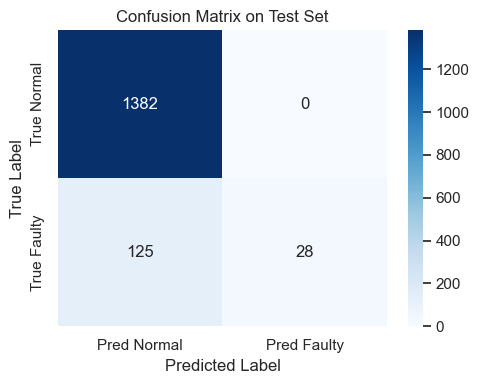

In [9]:
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Pred Normal','Pred Faulty'],
    yticklabels=['True Normal','True Faulty']
)
plt.title("Confusion Matrix on Test Set")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


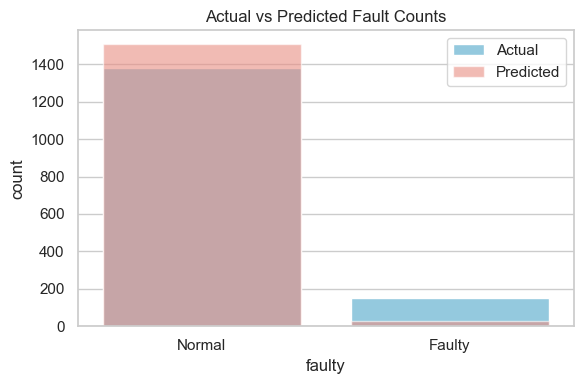

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_test, color='skyblue', label='Actual')
sns.countplot(x=y_pred_test, color='salmon', alpha=0.6, label='Predicted')
plt.xticks([0,1], ['Normal','Faulty'])
plt.title("Actual vs Predicted Fault Counts")
plt.legend()
plt.tight_layout()
plt.show()


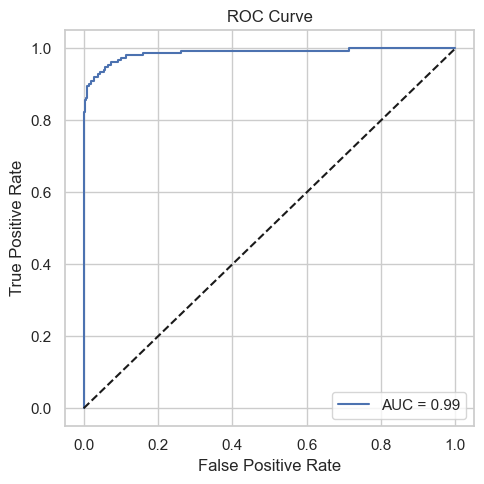

In [11]:
from sklearn.metrics import roc_curve, auc

# Use decision_function for scores
scores_test = model.decision_function(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, -scores_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


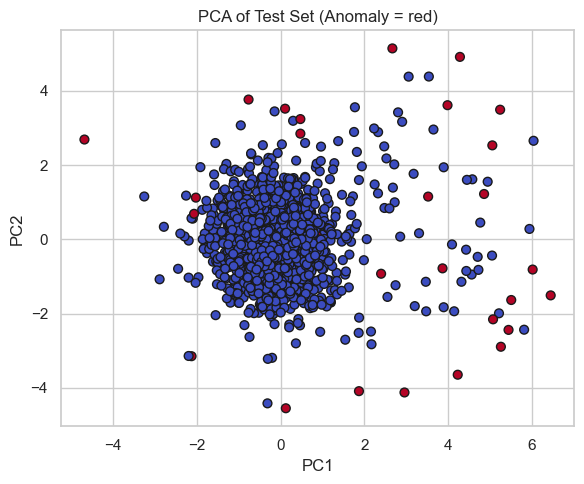

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(6,5))
plt.scatter(
    pcs[:,0], pcs[:,1],
    c=y_pred_test, cmap='coolwarm',
    edgecolor='k', s=40
)
plt.title("PCA of Test Set (Anomaly = red)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


In [13]:
# ===== After training and predictions =====

from sklearn.metrics import classification_report

# Assume you have:
#   y_train, y_test         # true labels
#   y_pred_train, y_pred_test  # predicted labels (0 for normal, 1 for anomaly)

print("Training Classification Report:")
print(classification_report(
    y_train,
    y_pred_train,
    labels=[0.0, 1.0],
    target_names=['0.0','1.0'],
    digits=2
))

print("Testing Classification Report:")
print(classification_report(
    y_test,
    y_pred_test,
    labels=[0.0, 1.0],
    target_names=['0.0','1.0'],
    digits=2
))


Training Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      5523
         1.0       1.00      0.10      0.18       614

    accuracy                           0.91      6137
   macro avg       0.95      0.55      0.57      6137
weighted avg       0.92      0.91      0.88      6137

Testing Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      1382
         1.0       1.00      0.18      0.31       153

    accuracy                           0.92      1535
   macro avg       0.96      0.59      0.63      1535
weighted avg       0.93      0.92      0.89      1535

